In [81]:
import os
import time
import cv2
import numpy as np
import requests as req
import IPython
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from utils import show_image
from IPython.display import clear_output

In [25]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [26]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [27]:
tf.__version__

'2.4.0-rc1'

In [72]:
%matplotlib inline

Load the saved model, trained using a pre-trained model on a different dataset.

In [6]:
print("Loading model...")
start_time = time.time()
detect_fn = tf.saved_model.load('../exported-models/ssd_mobilenet_v2/saved_model')
print('Loading took {} seconds.'.format(time.time()-start_time))

Loading model...
Done! Took 54.709129333496094 seconds


Load model labels

In [64]:
category_index = label_map_util.create_category_index_from_labelmap(
    '../annotations/label_map.pbtxt', 
    use_display_name=True
)

Do inference

In [73]:
#URL = 'https://www.vegvesen.no/public/webkamera/kamera?id=2580261' # 'LIVE' inference.
URL = 'https://www.vegvesen.no/public/webkamera/kamera?id=2992499'

In [75]:
def get_image(url, flags=cv2.IMREAD_COLOR):
    try:
        r = req.get(url)
        if r.status_code != 200: # Is the camera down?
            return None
        img = cv2.imdecode(np.frombuffer(r.content, dtype=np.uint8), flags)
        img = img[25:,:,:] # Crop away the top black bar.
        return img
    except:
        print("Response timed out!")
        return None

def inference(image_np, input_tensor, visualize_img=False):
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    start_time = time.time()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=70,
        min_score_thresh=0.45,
        agnostic_mode=False,
        line_thickness=1,
        mask_alpha=0.4
    )
    print('Inference took {} seconds'.format(time.time()-start_time))
    if visualize_img:
        show_image(image_np, size=(16,12))
        
def inference_url(url, visualize_img=False):
    img = get_image(url)
    if img is None:
        return
    inference(img, tf.convert_to_tensor(img), visualize_img)

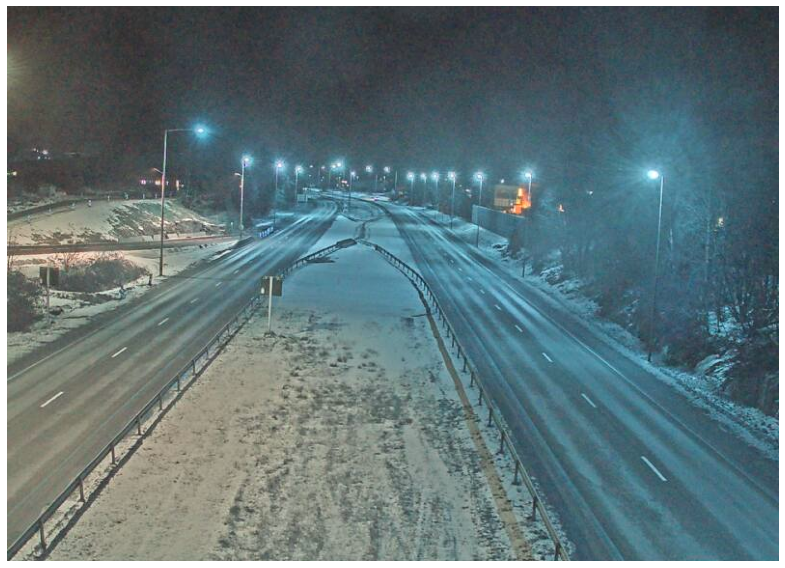

In [76]:
# Test
show_image(get_image(URL))

Inference took 0.0 seconds


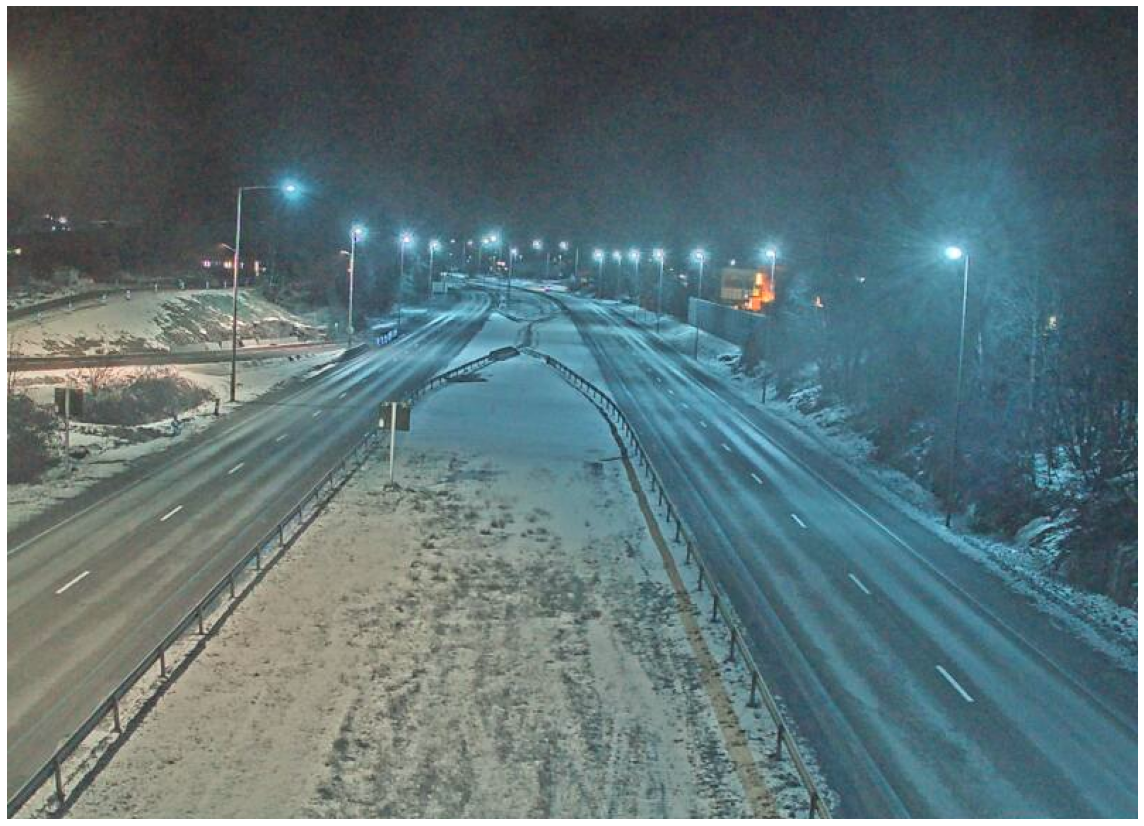

In [85]:
inference_url(URL, True)

Inference took 0.0 seconds


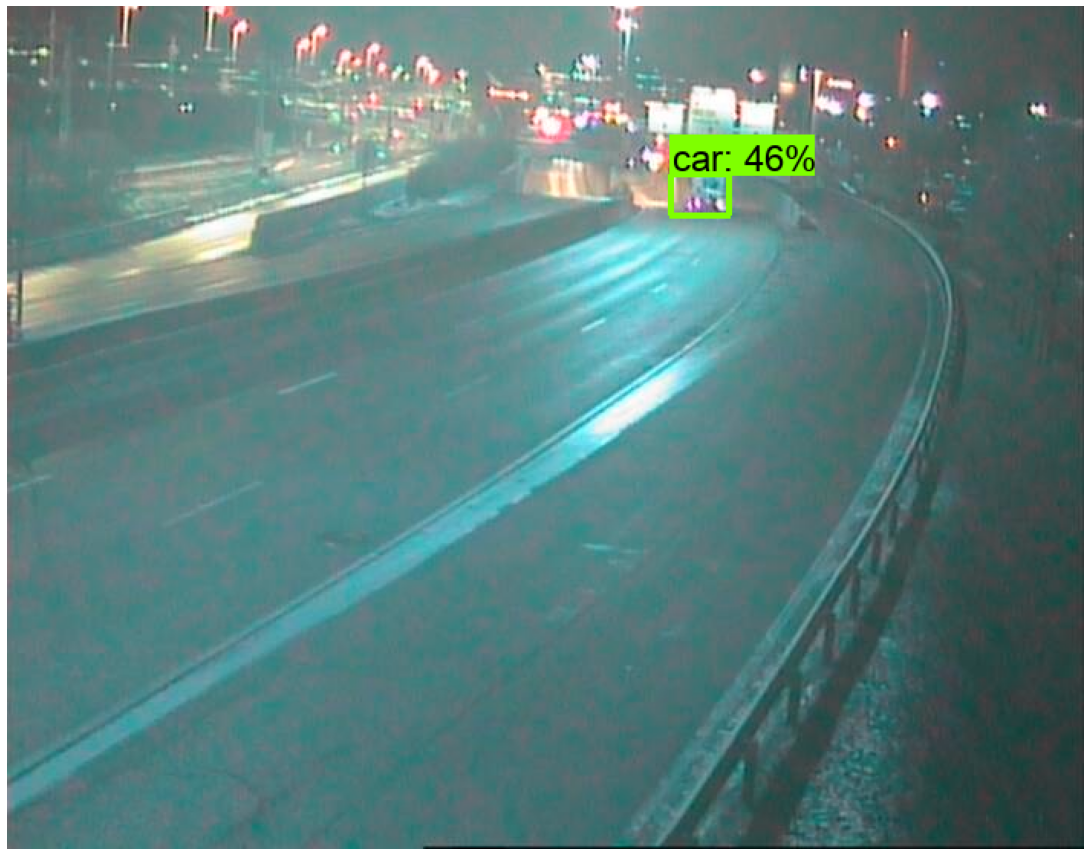

In [40]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=297619', True)

Inference took 0.0 seconds


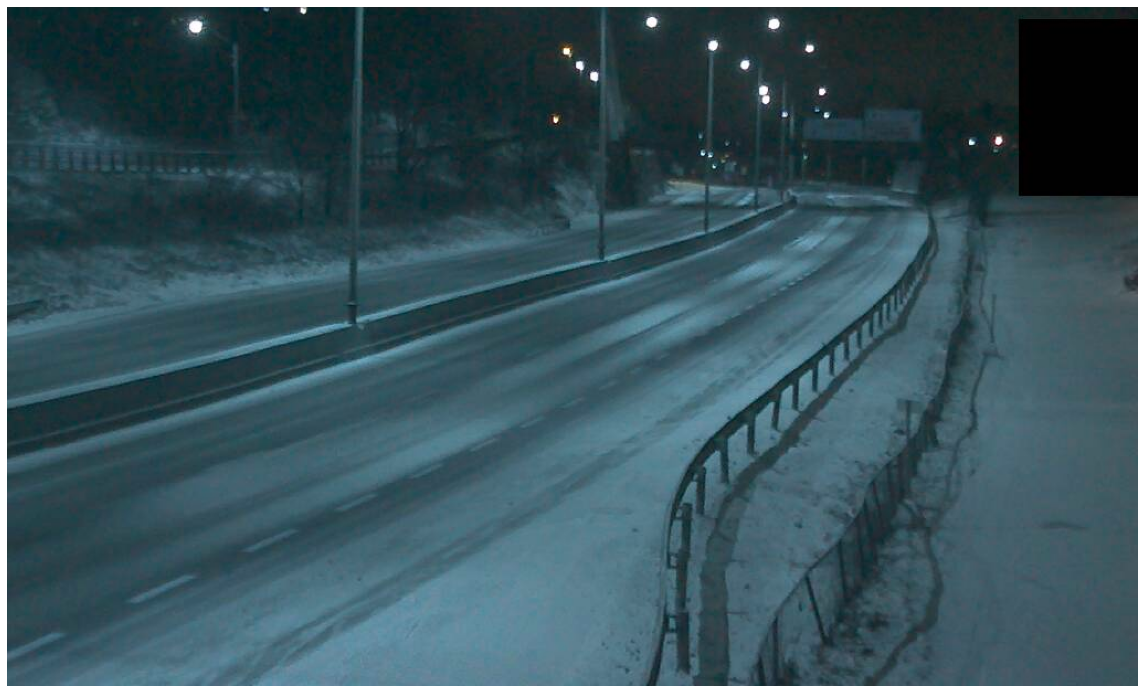

In [84]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=640748', True)

In [79]:
STREAM = 'https://kamera.vegvesen.no/public/0329001_1/hls_1_stream_1_orig.m3u8'

Inference took 0.0 seconds


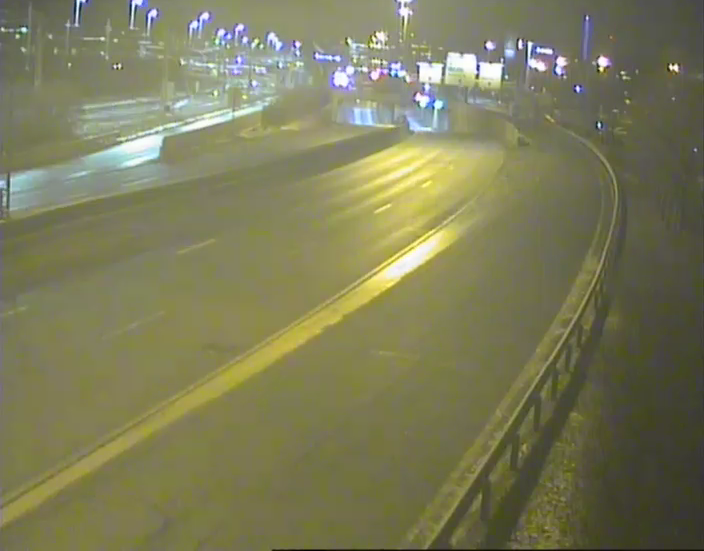

Stopped Video Stream


In [83]:
vstream = None
try:
    print("Started Video Stream")
    vstream = cv2.VideoCapture(None)
    vstream.open(STREAM)
    while True:
        ret, frame = vstream.read()
        if ret:
            clear_output(wait=True)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame[25:,:,:] # Crop away the top black bar.
            inference(frame, tf.convert_to_tensor(frame), False)
            IPython.display.display(Image.fromarray(frame))
        time.sleep(2)
except:
    print("Stopped Video Stream")
finally:
    vstream.release()